<a href="https://colab.research.google.com/github/jshogland/SpatialModelingTutorials/blob/main/Notebooks/UseCase3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fire Resilience

#### This notebook demonstrates how Raseter Tools and ancillary data can be used to identify and quantify treatment locations and cost of implementation to reduce fire risk and create fire resilient landscapes. Datasets used in this notebook include raster surfaces created in [Riely et al. 2016](https://esajournals.onlinelibrary.wiley.com/doi/10.1002/ecs2.1472), roads, streams, water bodies, sawmill locations, [potential operational delineations (PODs)](https://www.fs.usda.gov/research/rmrs/projects/pods), and a digital elevation model.

#### Author: John Hogland 5/22/2023

## Overview
#### Using various data sources we will estimate the potential biomass removals and costs associated with transforming the Stanislaus National Forest into a more fire resilient landscape. To help navigate these steps the notebook has been split into five sections:
1. Installing software
2. Downloading the data
3. Linking summarized FIA data with tree lists
4. Defining Desired Future Conditions for a fire resilient landscape
5. Quantifying potential costs
6. Linking potential costs with potential removals

#### Step 1: Installing software
##### This step is meant to install Raster Tools and upgrade various packages on [Google's Colab](https://colab.research.google.com/). If working locally and raster tools has already been installed, this step can be skipped.

In [1]:
!pip install --upgrade gdown
!pip install --upgrade numba
!pip install --upgrade geopandas
!pip install mapclassify
!pip install --upgrade datascience
!pip install --upgrade gym
!pip install --upgrade folium
!pip install leafmap xarray_leaflet
!pip install localtileserver
!pip install osmnx
!pip install py3dep
!pip install raster_tools

  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 MB 13.8 MB/s eta 0:00:00
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.39.1
    Uninstalling llvmlite-0.39.1:
      Successfully uninstalled llvmlite-0.39.1
  Attempting uninstall: numba
    Found existing installation: numba 0.56.4
    Uninstalling numba-0.56.4:
      Successfully uninstalled numba-0.56.4
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.7/721.7 kB 9.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  C

#### Step 2: Download the data
We will be using 3 main sources of data for this notebook; the Forest Service Research Data Archive, the Open Street Maps (OSM) project, and USGS 3DEP program. To download the tree data for this notebook run the cell Get Tree list data. After downloading the tree list data and extracting the zipped contents you will have a ".\data" directory containing the raster surfaces created within the [Riely 2016](https://esajournals.onlinelibrary.wiley.com/doi/10.1002/ecs2.1472) study and supporting crosswalk and tree list tables. While the tree list data covers all of Conus USA, we only need the boundary of the Stanislaus National Forest for our example. Using the boudary of the Stanislaus National Forest we will subset the tree list data and download roads, streams, sawmills, and elevation data. For roads, streams, and sawmill locations we will leverage the Open Street Maps (OSM) project. To download OSM vector datasets run the Get OSM data cell. For elevation data we will download National Elevation Dataset (NED) 30 m DEMs from USGS 3DEP project. To download elevation data run the Get DEM data cell. Finally, to download potential operational delineations, we will extract the Stanislaus National Forest POD boundaries from the google drive (Get PODs cell).   

#### Files we will be using in this notebook include:
- national_c2016_tree_list = tree list raster
- TL_CN_Lookup = look up table matching TID numbers with Raster values
- Tree_table_Conus = Tree tables in Text format
- OSM roads
- OSM streams
- OSM sawmills
- 3DEP DEM
- POD boundaries
- FIA Species Codes

In [2]:
from raster_tools import Raster, distance, general, Vector, open_vectors, clipping, surface, creation
import numpy as np, geopandas as gpd, pandas as pd, osmnx as ox, py3dep
import gdown, zipfile


In [3]:
# Get Tree List Data
url='https://s3-us-west-2.amazonaws.com/fs.usda.rds/RDS-2021-0074/RDS-2021-0074_Data.zip'
outfl = r"./SNF_Notebook_data.zip"
gdown.download(url=url, output=outfl, quiet=False, fuzzy=True)

with zipfile.ZipFile(outfl, "r") as zip_ref:
    zip_ref.extractall(".")


Downloading...
From: https://s3-us-west-2.amazonaws.com/fs.usda.rds/RDS-2021-0074/RDS-2021-0074_Data.zip
To: /content/SNF_Notebook_data.zip
100%|██████████| 5.45G/5.45G [04:39<00:00, 19.5MB/s]


In [4]:
#Get OSM data

#get the boundary of the Stanislaus from OSM and the location of California Wood Shavings
snf=ox.geocode_to_gdf('Stanislaus National Forest, CA, USA')
ply=snf.buffer(0.25)
geo=ply[0]

#get the location of the California Wood Shavings mill
sawmill=ox.geocode_to_gdf('California Wood Shavings')

#download road and stream data
roads=ox.geometries_from_polygon(geo,{'highway':['motorway','trunk','primary','secondary','tertiary','unclassified','residential']})
streams=ox.geometries_from_polygon(geo,{'waterway':['river','stream','cannel','ditch']})
wbdy=ox.geometries_from_polygon(geo,{'water':['lake','reservoir','pond']})


<ipython-input-4-533fb3fe1d19>:5: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  ply=snf.buffer(0.25)
<ipython-input-4-533fb3fe1d19>:12: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  roads=ox.geometries_from_polygon(geo,{'highway':['motorway','trunk','primary','secondary','tertiary','unclassified','residential']})
<ipython-input-4-533fb3fe1d19>:13: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  streams=ox.geometries_from_po

In [5]:
#Get 3Dep data
dem=py3dep.get_map('DEM',geo,resolution=30).expand_dims({'band':1})#add band dimension to the xarray dataset

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:

In [6]:
#Get PODs data and FIA Species Codes
url='https://drive.google.com/file/d/1KBK3bpjgKDcpEeuylRo6zxwdSAtyuHCm/view?usp=sharing'
outfl = r"./STF_PODS_2020_V1.zip"
gdown.download(url=url, output=outfl, quiet=False, fuzzy=True)

with zipfile.ZipFile(outfl, "r") as zip_ref:
    zip_ref.extractall(".")


Downloading...
From: https://drive.google.com/uc?id=1KBK3bpjgKDcpEeuylRo6zxwdSAtyuHCm
To: /content/STF_PODS_2020_V1.zip
100%|██████████| 2.05M/2.05M [00:00<00:00, 47.5MB/s]


In [7]:
#Clip tree list data and project other datasets to the same projection as the tree list

tlst=Raster('./Data/TreeMap2016.tif')
pods=(open_vectors('STF_PODS_2020_V1.shp').data.compute()).to_crs(tlst.crs)

snf_ply=ply.to_crs(tlst.crs)

snf_tlst=clipping.clip(clipping.get_vector(snf_ply),tlst)
snf_elv=Raster(dem.rio.reproject_match(snf_tlst.xdata))
snf_roads=roads.to_crs(tlst.crs).reset_index()
snf_streams=streams.to_crs(tlst.crs).reset_index()
snf_wbdy=wbdy.to_crs(tlst.crs).reset_index()
snf_sawmill=sawmill.to_crs(tlst.crs).centroid
snf_dem=Raster(dem.rio.reproject_match(snf_tlst.xdata))
snf_pods=pods.to_crs(tlst.crs)


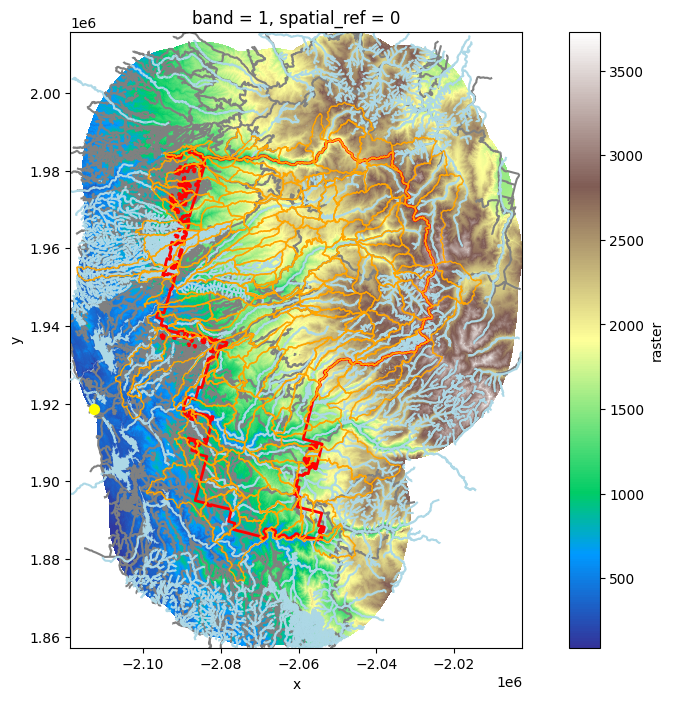

In [8]:
#visualize the projected data
p1=snf_roads.plot(color='gray',figsize=(12,8),zorder=1)
p2=snf_streams.plot(ax=p1, color='lightblue',zorder=2)
p3=snf_wbdy.plot(ax=p2, color='lightblue',zorder=3)
p4=(snf.to_crs(snf_tlst.crs)).plot(ax=p3,edgecolor='red',facecolor='none',linewidth=2,zorder=4)
p5=snf_pods.plot(ax=p4, edgecolor='orange',facecolor='none',zorder=5)
p6=snf_sawmill.plot(ax=p5, color = 'yellow',markersize=50,zorder=6)
p7=snf_dem.plot(ax=p6,cmap='terrain',zorder=0)
p7


#### Step 3: Linking summarized FIA data with tree lists
To link national_c2014_tree_list.tif raster surface to the summarized tree list values we will do the following:
1. Filter Tree_table_CONUS.txt to the TIDs of the clipped c2014_tree_list.tif raster
2. Summarize Tree_table_CONUS.txt by TIDs
3. Reclassify C2014_tree_list.tif to summarized values
4. Save out raster surfaces.

In [9]:
t_vls,t_cnt=np.unique(snf_tlst,return_counts=True)
tree_tbl=pd.read_csv('./Data/TreeMap2016_tree_table.csv',sep=',')


In [10]:
t_vls

array([      1009,       1583,       3739, ...,      82486,      82503,
       2147483647], dtype=int32)

In [11]:
tree_tbl.columns

Index(['tm_id', 'CN', 'STATUSCD', 'TPA_UNADJ', 'SPCD', 'COMMON_NAME',
       'SCIENTIFIC_NAME', 'SPECIES_SYMBOL', 'DIA', 'HT', 'ACTUALHT', 'CR',
       'SUBP', 'TREE', 'AGENTCD'],
      dtype='object')

In [12]:
#subset data to values in raster
tree_tbl_sub=tree_tbl[tree_tbl['tm_id'].isin(t_vls)]
rspc=pd.read_csv('REF_SPECIES_jen.csv',delimiter=',').dropna()
usp=np.unique(tree_tbl_sub['SPCD'])
rspc=rspc[rspc['SPCD'].isin(usp)]

#Join Biomass equation coefficients with tree table
tree_tbl_sub=tree_tbl_sub.merge(rspc,on='SPCD')

#calculate basal area ft squared per acre (BAA)
tree_tbl_sub['BAA']=(tree_tbl_sub['DIA']**2)*0.005454*tree_tbl_sub['TPA_UNADJ']

#calculate pounds per acre (AGB)
tree_tbl_sub['AGB']=(np.exp(tree_tbl_sub['JENKINS_TOTAL_B1'] + tree_tbl_sub['JENKINS_TOTAL_B2'] * np.log(tree_tbl_sub['DIA']*2.54))*2.2046)*tree_tbl_sub['TPA_UNADJ']#bone dry pounds per acre

#calculate stem pounds per acre (SAGB)
tree_tbl_sub['SAGB']=(np.exp(tree_tbl_sub['JENKINS_STEM_WOOD_RATIO_B1'] + tree_tbl_sub['JENKINS_STEM_WOOD_RATIO_B2'] / (tree_tbl_sub['DIA']*2.54)))*tree_tbl_sub['AGB']#bone dry pounds per acre

#create needle (n) and broad (b) leaf groups (LTYPE)
tree_tbl_sub['LTYPE']=np.where(tree_tbl_sub['SPCD']<300,"n","b")

#create regen vs merch groups
tree_tbl_sub['MTYPE']=np.where(tree_tbl_sub['DIA']<5,'regen','merch')

#split based on species code (live, dead)
l_tree_tbl_sub = tree_tbl_sub[tree_tbl_sub['STATUSCD']==1]

#summarize by plot and leaf type (LTYPE) and keep BAA TONS
l_tree_sum=(l_tree_tbl_sub.groupby(['tm_id','LTYPE','MTYPE']).sum())[['BAA','TPA_UNADJ','AGB','SAGB']]

#calculate QMD
l_tree_sum['QMD'] = ((l_tree_sum['BAA']/l_tree_sum['TPA_UNADJ'])/0.005454)**0.5

#display the summarized table
display(l_tree_sum)



BAA    TPA_UNADJ           AGB          SAGB  \
tm_id LTYPE MTYPE                                                       
1009  b     merch  29.849368   120.360920  26931.267908  14982.901123   
1583  b     merch  31.377252   108.324828  29378.989065  16408.656585   
            regen   6.218770    74.965280   5824.933724   2496.786428   
3739  b     merch   9.755152    30.090230   4980.599693   2824.969079   
      n     merch  20.256030    60.180460  16077.128008  10234.525659   
...                      ...          ...           ...           ...   
82483 n     regen  60.364184  2248.958400  29287.381514  15646.954780   
82486 n     merch   1.708079    12.036092   1067.779868    641.920017   
            regen  56.443211  2173.993120  27465.754428  14690.396129   
82503 n     merch  78.718017   174.523334  41676.231153  26741.325888   
            regen  10.667174   149.930560   6133.048661   3568.614328   

                        QMD  
tm_id LTYPE MTYPE            
1009  b     merch  6.743219  
1583  b     merch  7.287623  
            regen  3.900000  
3739  b     merch  7.709864  
      n     merch  7.855826  
...                     ...  
82483 n     regen  2.218408  
82486 n     merch  5.100980  
            regen  2.181821  
82503 n     merch  9.093954  
            regen  3.611786  

[9451 rows x 5 columns]

In [13]:
#split out baa, tpa, and biomass types
plot_nm=(l_tree_sum[(l_tree_sum.index.get_level_values('MTYPE')=='merch')&(l_tree_sum.index.get_level_values('LTYPE')=='n')]).reset_index(level=[1,2])
plot_bm=(l_tree_sum[(l_tree_sum.index.get_level_values('MTYPE')=='merch')&(l_tree_sum.index.get_level_values('LTYPE')=='b')]).reset_index(level=[1,2])
plot_nr=(l_tree_sum[(l_tree_sum.index.get_level_values('MTYPE')=='regen')&(l_tree_sum.index.get_level_values('LTYPE')=='n')]).reset_index(level=[1,2])
plot_br=(l_tree_sum[(l_tree_sum.index.get_level_values('MTYPE')=='regen')&(l_tree_sum.index.get_level_values('LTYPE')=='b')]).reset_index(level=[1,2])
rm_lst=[plot_nm,plot_bm,plot_nr,plot_br]
at_lst=plot_nm.columns[-5:]

print(at_lst)

Index(['BAA', 'TPA_UNADJ', 'AGB', 'SAGB', 'QMD'], dtype='object')


In [14]:
#Reclassify tree list raster to various BAA, TPA, AGB, SAGB, and QMD raster surfaces using summarized plot data
rs_lst=[]
for a in at_lst:
    t_lst=[]
    for r in rm_lst:
        rs = snf_tlst.reclassify(r[a].astype('int32').to_dict(),unmapped_to_null=True)
        t_lst.append(rs.where(~rs.to_null_mask(),0)) #set null values to zero and append raster to temp list
    rs_lst.append(general.band_concat(t_lst))

baa,tpa,agb,sagb,qmd=rs_lst #each raster is a 4 band surface with band estimates corresponding to needle leaf merch species, broadleaf  merch specie, needle leaf regen species, broad leaf regen species


#### Step 4: Defining desired future condition (DFC)
DFC are define based on spatial locations as described in **Table 1**.

<h4 style="text-align: Left;">
    <b>Table 1.</b> Criteria used to identify desired future condition (DFC).
</h4>
   
|Feature|Characteristic|Threshold|Desired BAH|
|:-:|:-:|:-:|:-:|
|POD Boundary|Distance From|distance < 610 meters|20.5 m<sup>2</sup> ha<sup>-1</sup>|
|POD Boundary|Distance From|distance > 610 meters|See Aspect Feature|
|deferred|Area|NA|Existing BAH|
|Water|Distance From|distance < 30.48 meters|Existing BAH|
|Water|Distance From|distance > 30.48 meters|See Aspect Feature|
|Elevation|Slope|slope < 50%|See Aspect Feature|
|Elevation|Slope|slope > 50%|Existing BAH|
|Elevation|Aspect|290<sup>o</sup><Aspect<360<sup>o</sup> or 0<sup>o</sup><Aspect<70<sup>o</sup> |38 m<sup>2</sup> ha<sup>-1<sup/>|
|Elevation|Aspect|70<sup>o</sup><Aspect<290<sup>o</sup>|27.5 m<sup>2</sup> ha<sup>-1<sup/>|

POD = potential wildland fire operations delineations

In [15]:
#summarize baa and convert baa (ft sqaured per acre) to bah (m squared per hectare)
bah=general.local_stats(baa,'sum')*0.229568
ttonne=(agb/2000*0.907185)*0.404686*0.09

#create distance surfaces for pods and water
d_pods=distance.pa_proximity(Vector(snf_pods.boundary).to_raster(snf_dem))
s_rs=Vector(snf_streams).to_raster(snf_dem)
w_rs=Vector(snf_wbdy).to_raster(snf_dem)
d_water=distance.pa_proximity(w_rs.where(~w_rs.to_null_mask(),s_rs))

#create slope and aspect surfaces
slp_rs=surface.slope(snf_dem,False)
asp_rs=surface.aspect(snf_dem)

#create dfc bah
ach=((asp_rs<360) & (asp_rs>290)) | ((asp_rs<70) & (asp_rs>0))
asp_bah=(ach * 38).where(ach,27.5)
dch=d_pods<610
p_bah=(dch*20.5).where(dch,asp_bah)
t1=p_bah.where((slp_rs<0.5),bah)
dfc=t1.where(d_water>30.48,bah)

#calc removals to meet DFC
rem_rs = bah-dfc
rem_rs = rem_rs.where((rem_rs > 0),0)

#calc % removed BAH and estimate AGB removed to meet DFC (tonne)
pr_bah=rem_rs/bah
tonne_rm=general.local_stats(ttonne,'sum') * pr_bah

#### Step 5: Quantifying potential costs
The potential costs methodology estimate the costs of removing biomass on per tonne basis using machine rates and spatial analyses. Transportation costs are estimated using OSM roads segments, the rate of travel presented in **Table 2**, and log truck machine rates presented in **Table 3**. Extraction costs are estimated using **Table 3** machine rates. The potential treatment cost estimation approach is described in detail in [Hogland et. al. 2018](https://www.mdpi.com/2220-9964/7/4/156) and [2021](https://www.mdpi.com/1999-4907/12/8/1084).

**Table 2**. Road segment travel speed by [OSM highway](https://wiki.openstreetmap.org/wiki/Key:highway) class types.

|Query|Speed (KPH)|
|:-|:-:|
|Residential|40|
|Unclassified|24|
|Tertiary|56|
|Secondary|72|
|Primary|88|
|Trunk|88|
|Motorway|105|

**Table 3**. Criteria used to spatially define harvesting systems and treatment costs. Machine rate of travel, and capacity estimates derived from meetings with Lisa Ball, Jacob Baker, Michael Jow, and Brian McCrory.

|Component|System|Rate|Rate of travel|Payload|Where it can occur|
|:-:|:-:|:-:|:-:|:-:|:-:|
|       |Rubber tire skidder|\$165/hr|2.4 KPH|1.36 Tonne|Slopes <= 35% and Next to Roads ( distance < 460 m from a road).|
|Offroad|Skyline|\$400/hr|3.2 KPH|1.13 Tonne|Slopes > 35% and within 305 m of a road.|
|       |Helicopter|\$8,000/hr|3.8 KPH|1.82 Tonne|Areas not covered by the other two and distance < 915 m from landing area.|
|Felling|Feller buncher|\$16.32/Tonne|NA|NA|Slopes <= 35%|
|       |Hand Felling|\$29.39/Tonne|NA|NA|Slopes > 35%|
|Processing|Delimbing, cutting to length, chipping, and loading|\$60.9/Tonne|NA|NA|NA|
|On road|Log Truck|\$98/hour|Table 1|13.3 Tonne|NA|
|Additional Treatments|Hand Treatment|\$1000/ha|NA|NA|Forested Areas|
|       |Prescribed fire|\$1000/ha|NA|NA|Forested Areas|

In [16]:
h_speed={'residential':40,'unclassified':24,'tertiary':56,'secondary':72,'primary':88,'trunk':88,'motorway':105}

#offroad rates of travel
sk_r=2.4
cb_r=3.2
hl_r=3.8

#component rates $ per hour or unit area
sk_d=165
cb_d=400
hl_d=8000
fb_d=16.32
hf_d=29.39
pr_d=60.9
lt_d=98
ht_d=1000
pf_d=1000

#payloads tonne
sk_p=1.36
cb_p=1.13
hl_p=1.82
lt_p=13.3

#set speed for road segments
snf_roads['speed']=snf_roads['highway'].map(h_speed)
snf_roads['speed'].where(snf_roads['maxspeed'].isna(),snf_roads['maxspeed'].str.slice(0,2).astype(float))
snf_roads['conv']=2*(((1/(snf_roads['speed']*1000))*lt_d)/lt_p) #1000 converts kilometers per hour to meters per hour

#snap sawmill facility to road vertices
print("Snapping sawmills to roads")
smill_b=sawmill.to_crs(snf_dem.crs)
tmp_rds=snf_roads
tmp_rds_seg=tmp_rds.sindex.nearest(smill_b.geometry,return_all=False)[1]
lns=tmp_rds.iloc[tmp_rds_seg].geometry.values
smill_b['cline']=lns
smill_b['npt']=smill_b.apply(lambda row: row['cline'].interpolate(row['cline'].project(row['geometry'].centroid)),axis=1)#, result_type = 'expand')
saw=Vector(smill_b.set_geometry('npt').set_crs(smill_b.crs))

#create barriers to off road skidding
bar2=(d_water>0).set_null_value(0)


# create slope and road distance surfaces
print("Creating base layers to threshold")
slp = slp_rs.eval() #compute so that slope only needs to be calculated once
c_rs = creation.constant_raster(snf_elv).set_null_value(0) #constant value of 1 to multiply by distance
rds_rs = (Vector(snf_roads).to_raster(snf_elv,'conv').set_null_value(0)).eval() #source surface with all non-road cells (value of zero) set to null


# convert on road rates and payload into on road cost surface that can be multiplied by the surface distance along a roadway to estimate hauling costs
print("Calculating on road hauling costs")
saw_rs=(saw.to_raster(snf_elv).set_null_value(0)).eval()
on_d_saw = distance.cda_cost_distance(rds_rs,saw_rs,snf_elv)

# convert onroad surfaces to source surfaces measured in cents / tonne
src_saw = (on_d_saw * 100).astype(int)

# create offroad surface distance surfaces that can be muliplied by rates to estimate dollars per unit
print("Calculating offroad costs")

#barriers to motion
b_dst_cs2=bar2#.set_null_value(0) # skidding and cable

#calc distance
saw_d,saw_t,saw_a=distance.cost_distance_analysis(b_dst_cs2,src_saw,snf_elv)
saw_d=saw_d.where(saw_d>0,np.nan)
saw_d=saw_d.where(saw_a>0,np.nan)

# Onroad, offroad, Felling, processing costs, and Additional Treatments
print("Calculating additional felling, processing, and treatment costs")
f1=slp<=0.35
fell=(f1*fb_d).where(f1,hf_d)
prc=creation.constant_raster(snf_elv,pr_d).astype(float)
oc=fell+prc

#Additional treatment costs (per/ha)
ht_cost=creation.constant_raster(snf_elv,(ht_d*0.09)).astype(float) #0.09ha per cell
pf_cost=creation.constant_raster(snf_elv,(pf_d*0.09)).astype(float) #0.09ha per cell
#add_treat_cost=a_t*frst

# Convert offroad rates to a mulitiplier that can be used to calculate dollars per tonne given distance
print("Combining costs...")
s_c= (2 * (((1/(sk_r*1000))*sk_d)/sk_p))
c_c= (2 * (((1/(cb_r*1000))*cb_d)/cb_p))
h_c= (2 * (((1/(hl_r*1000))*hl_d)/hl_p))

# Calculate potential saw costs $/Tonne
sk_saw_cost=(saw_d * s_c) + (saw_a/100) + oc
cb_saw_cost=(saw_d * c_c) + (saw_a/100) + oc
hd_saw_cost=(saw_d * h_c) + (saw_a/100) + oc

# Operations
rd_dist=distance.cda_cost_distance(c_rs,(rds_rs>0).astype(int),snf_elv)

sk=f1 & (rd_dist<460)
cb=((slp>0.35) & (rd_dist<305))*2
skcb=sk+cb
opr=(skcb.where(skcb>0,3) * (rd_dist<915)).astype(float)

#Create final rasters
o1=opr==1
o2=opr==2
o3=opr==3
sc1=sk_saw_cost*o1
sc2=cb_saw_cost*o2
sc3=hd_saw_cost*o3
saw_cost=sc1+sc2+sc3 #total cost $/tonne to remove material
add_tr_fr_cost=ht_cost+pf_cost #additional cost to implement prescribed burning and hand treatments


Snapping sawmills to roads
Creating base layers to threshold
Calculating on road hauling costs
Calculating offroad costs
Calculating additional felling, processing, and treatment costs
Combining costs...


#### Step 6: Linking potential cost with potential removals

#### Defining potential treatment units
While DFC may not be in alignment with our current condition at the cell level, one cell alone may not be worth the time and effort to setup and implement a operational treatment unit. Likewise, the difference between DFC and the existing condition may be so close at the cell level that a treatment is unwarranted. To identify operational treatment areas that meet both conditions (enough biomass and a large enough region) we will select all cells that have at least 1 tonne of biomass needed to be removed and that when combined into a region of cells meeting that criteria account for at least 5 hectares.  

In [17]:
#potential treatment units
rgns=general.regions((tonne_rm>1).astype('int32'),neighbors=4,unique_values=[1]).set_null_value(0) #find unique region
vls, cnts=np.unique(rgns,return_counts=True) # summarize counts by each region
df=pd.DataFrame({'regions':vls,'counts':cnts}) #convert to dataframe
r_m_c=df[(df['counts']>55) & (df['regions']>0)] #select regions with counts greater than 55 (skip region 0, it is the background)
rdic=r_m_c.reset_index().set_index('regions')['index'].to_dict() #convert to dictionary for remapping
ptu=rgns.reclassify(rdic,True) # reclassify region map to index values for regions meeting criteria (potential treatment units; ptu)

#### Estimate potential cost, revenue, and profite at the cell level and summarize up to the treatment level

In [18]:
from dask import array as da, dataframe as ddf
def fz3(zrs,vrs,stats=["count","sum", "mean", "std",'min','max'],f_name=None):
    if(isinstance(zrs,Vector)):
        zrs=zrs.to_raster(vrs,field=f_name)

    b,x,y=zrs.shape
    cells=x*y
    df_lst=[zrs.data.reshape((cells,1))]
    n_lst=['zone']
    for b in range(vrs.nbands):
        n_lst.append('band_'+str(b+1))
        df_lst.append(vrs.data[b].reshape((cells,1)))

    ds_ar=da.concatenate(df_lst,axis=1)
    df=ds_ar.to_dask_dataframe(columns=n_lst)
    gdf=df.groupby('zone')
    return gdf.agg(stats)

#potential cost
pcost=tonne_rm*saw_cost
prev=tonne_rm*150 #using $150/tonne for gate prices here
pprofit=prev-pcost
stable=fz3(ptu,pprofit,['sum'])

In [19]:
ztbl=stable.compute()

In [20]:
ztbl=ztbl.reset_index()
ztbl=ztbl[ztbl['zone']>0]



In [21]:
ztbl

,zone,band_1
,,sum
1,22.0,0.000000
2,94.0,-6321.565759
3,123.0,0.000000
4,515.0,0.000000
5,529.0,-17372.178088
...,...,...
2758,265322.0,3821.167475
2759,265334.0,-113417.662038
2760,265434.0,-132726.647601


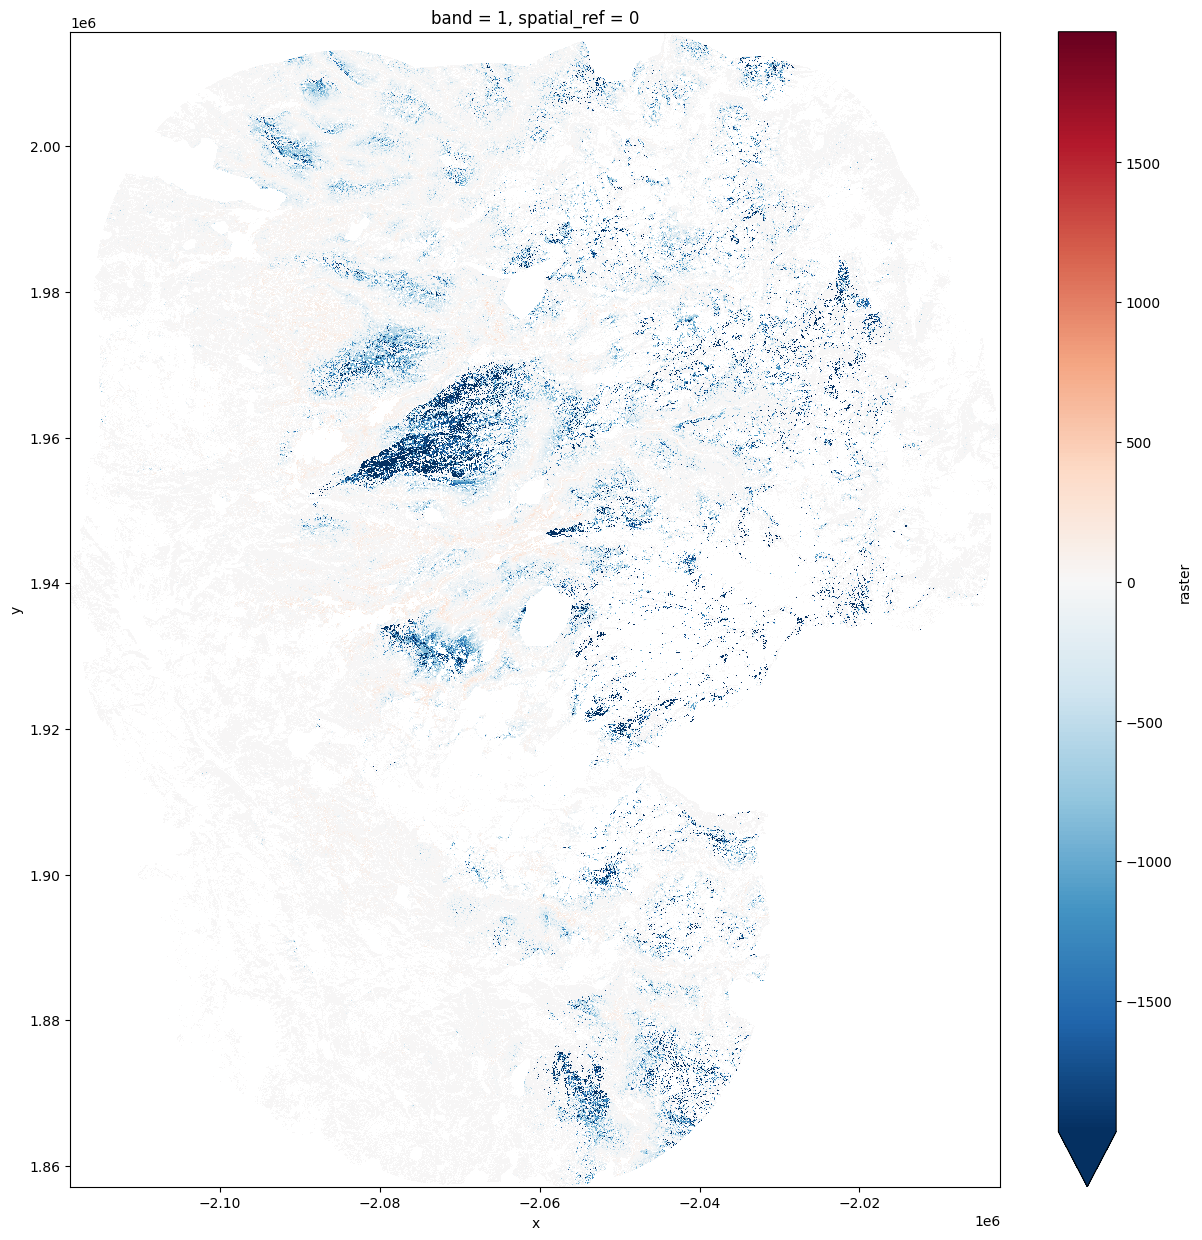

In [22]:
pprofit.plot(robust=True, figsize=(15,15))

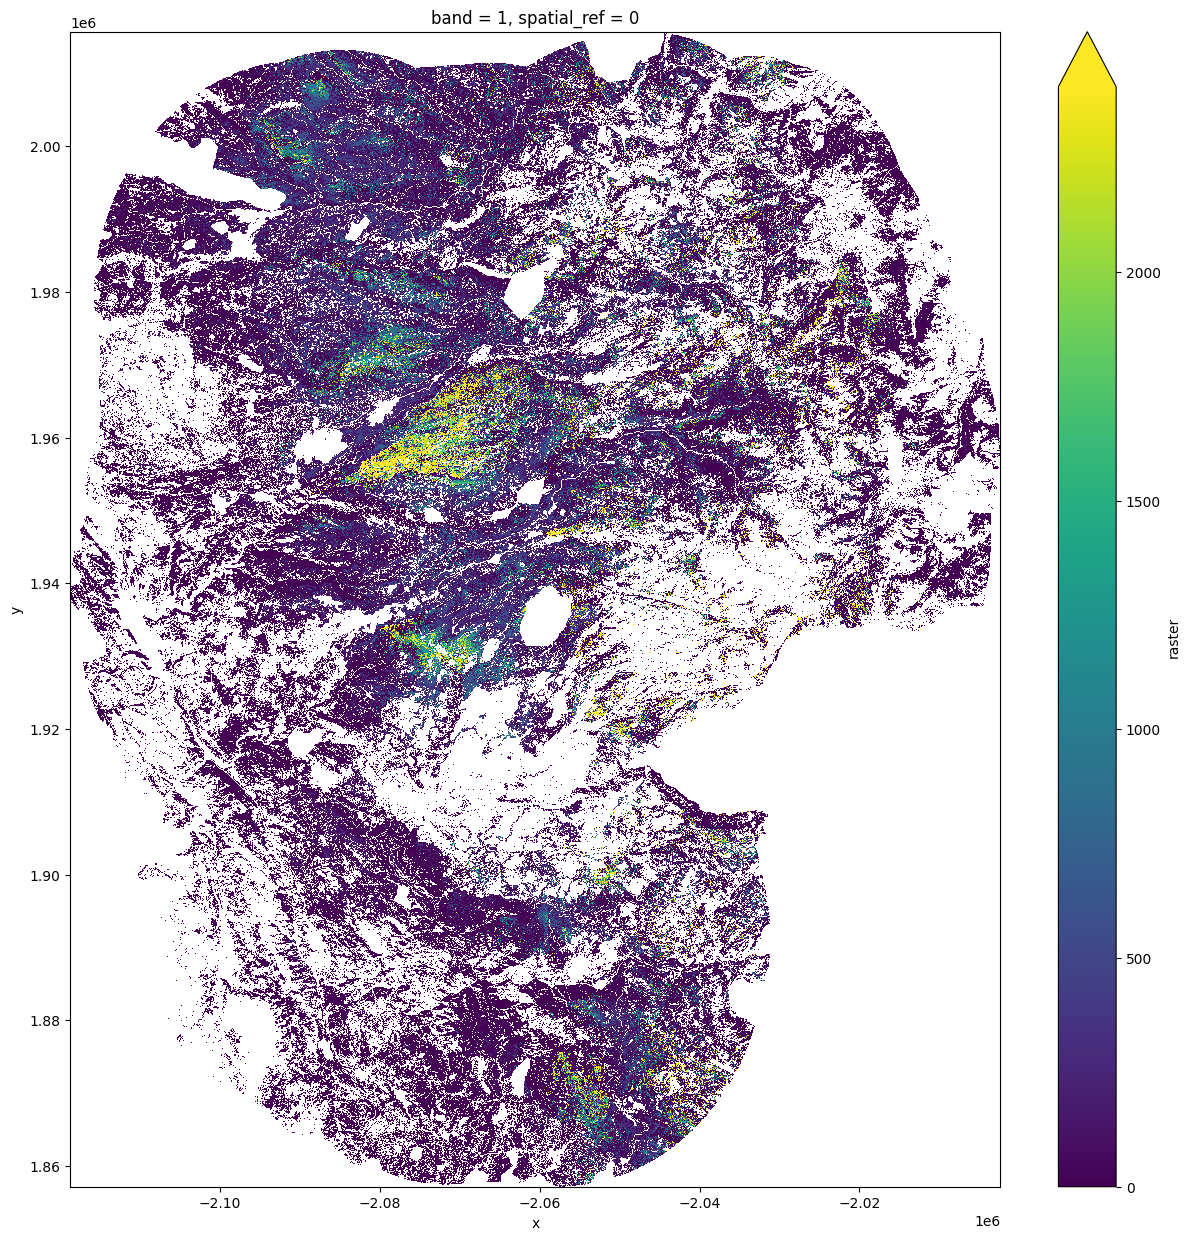

In [23]:
pcost.plot(robust=True,figsize=(15,15))